In [1]:
%cd /content/drive/MyDrive/ENS491\ Bitirme\ Projesi/Tests/Design \A/Swin3D

/content/drive/.shortcut-targets-by-id/10zTDcXHUyEVA0OzFw5rGtexJIwNrqbab/ENS491 Bitirme Projesi/Tests/Design A/Swin3D


In [2]:
!pip install timm
!pip install tensorflow_graphics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 29.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
import torch
import torch.nn as nn
import timm
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

import tensorflow as tf
import tensorflow_graphics.geometry.transformation as tfg_transformation
#from swin_functions_and_classes import *

In [4]:
from zipfile import ZipFile
import io

def getImageFromZip(zipobj, fname, imreadFlag):
  if fname in zipobj.namelist():
    image_data = zipobj.read(fname)
    image_buffer = io.BytesIO(image_data)
    return cv.imdecode(np.frombuffer(image_buffer.getvalue(), np.uint8), imreadFlag)
  else:
    raise ValueError("Error, given file does not exit")

In [5]:
path =  "/content/drive/.shortcut-targets-by-id/10zTDcXHUyEVA0OzFw5rGtexJIwNrqbab/ENS491 Bitirme Projesi/Tests/"
zip_file = path+"rgbd-scene-time-lapses.zip"
zipf = ZipFile(zip_file, 'r')

Pose information:
  9.9556482e-001	 -6.5185979e-002	 -6.7344189e-002	 -2.2585712e-001	
  8.6272076e-002	  9.1812646e-001	  3.8667411e-001	 -2.9204991e-001	
  3.6626484e-002	 -3.9078209e-001	  9.1970646e-001	  2.8553110e-001	
  0.0000000e+000	  0.0000000e+000	  0.0000000e+000	  1.0000000e+000	



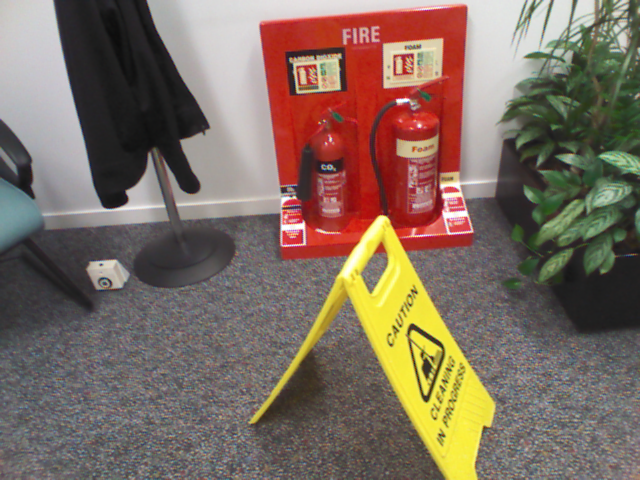

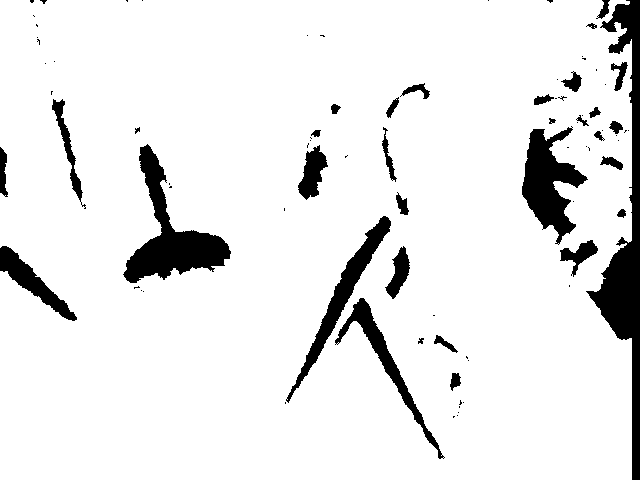

In [6]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Specify the path to the ZIP file
zip_file = "/content/drive/.shortcut-targets-by-id/10zTDcXHUyEVA0OzFw5rGtexJIwNrqbab/ENS491 Bitirme Projesi/Tests/rgbd-scene-time-lapses.zip"

# Open the ZIP file
with ZipFile(zip_file, 'r') as zipf:
    # Specify the file name of the target (pose) file
    pose_file_name = "fire/fire/seq-01/seq-01/frame-000000.pose.txt"

    # Check if the specified target file exists in the ZIP archive
    if pose_file_name in zipf.namelist():
        # Read the contents of the pose file
        with zipf.open(pose_file_name, 'r') as pose_file:
            # Read the contents of the file as text
            pose_contents = pose_file.read().decode('utf-8')

            # Print the contents of the pose file
            print("Pose information:")
            print(pose_contents)

            # Get the file name prefixes for color and depth files
            file_prefix = pose_file_name.replace('.pose.txt', '')

            # Construct the file names for color and depth images
            color_file_name = file_prefix + '.color.png'
            depth_file_name = file_prefix + '.depth.png'

            # Read the color image
            color_image_data = zipf.read(color_file_name)
            color_image = cv2.imdecode(np.frombuffer(color_image_data, np.uint8), cv2.IMREAD_COLOR)

            # Read the depth image
            depth_image_data = zipf.read(depth_file_name)
            depth_image = cv2.imdecode(np.frombuffer(depth_image_data, np.uint8), cv2.IMREAD_UNCHANGED)

            # Display the color and depth images
            cv2_imshow(color_image)
            cv2_imshow(depth_image)
    else:
        print("Specified pose file not found in the ZIP archive.")

In [7]:
import os

# Get the current working directory
directory = "/content/drive/.shortcut-targets-by-id/10zTDcXHUyEVA0OzFw5rGtexJIwNrqbab/ENS491 Bitirme Projesi/Tests/fire_color"

# Concatenate the current directory with additional directories
train_dir = directory
test_dir = directory
print(path)

/content/drive/.shortcut-targets-by-id/10zTDcXHUyEVA0OzFw5rGtexJIwNrqbab/ENS491 Bitirme Projesi/Tests/


In [8]:
from zipfile import ZipFile
import pandas as pd
import io
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class ZipImageDataset(Dataset):
    def __init__(self, zip_path, subset='train', train_path='./multi-scene-pose-transformer/datasets/7Scenes/abs_7scenes_pose.csv_fire_train.csv', test_path='./multi-scene-pose-transformer/datasets/7Scenes/abs_7scenes_pose.csv_fire_test.csv', transform=None):
        self.zip_path = zip_path
        self.transform = transform

        # Open the ZIP file
        self.zip_file = ZipFile(zip_path, 'r')

        if subset == 'train':
            # Get a list of image file names for training
            self.image_names = [name for name in self.zip_file.namelist() if
                                name.startswith('fire') and
                                (name.find('/seq-01/') != -1 or name.find('/seq-02/') != -1) and
                                name.endswith('.color.png')]
            # Load the CSV file containing pose data
            self.pose_df = pd.read_csv(train_path)

        elif subset == 'test':
            # Get a list of image file names for testing
            self.image_names = [name for name in self.zip_file.namelist() if
                                name.startswith('fire') and
                                (name.find('/seq-03/') != -1 or name.find('/seq-04/') != -1) and
                                name.endswith('.color.png')]
            # Load the CSV file containing pose data
            self.pose_df = pd.read_csv(test_path)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # Read color image file from ZIP
        color_image_data = self.zip_file.read(self.image_names[idx])
        color_image = Image.open(io.BytesIO(color_image_data))

        # Read pose file from ZIP
        #pose_file_name = self.image_names[idx]
        #pose_data = self.pose_df[self.pose_df['image_path'] == pose_file_name].iloc[:, -7:]

         # Remove repeated folder names in the path
        image_path_parts = self.image_names[idx].split('/')
        image_path_parts = [part for i, part in enumerate(image_path_parts) if i == 0 or part != image_path_parts[i - 1]]
        pose_file_name = '/'.join(image_path_parts)
        pose_data = self.pose_df[self.pose_df['img_path'] == pose_file_name].iloc[:, -7:].values[0]

        # Parse pose data from string format to a tensor
        pose_data = [float(value) for value in pose_data]
        pose_tensor = torch.tensor(pose_data, dtype=torch.float32)

        # Apply transformations if specified
        if self.transform:
            color_image = self.transform(color_image)

        return color_image, pose_tensor

# Define your transform pipeline
IMG_SIZE = 256
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Path to your ZIP file
zip_path = "/content/drive/.shortcut-targets-by-id/10zTDcXHUyEVA0OzFw5rGtexJIwNrqbab/ENS491 Bitirme Projesi/Tests/rgbd-scene-time-lapses.zip"

# Create train and test datasets
train_dataset = ZipImageDataset(zip_path, subset='train', transform=manual_transforms)
test_dataset = ZipImageDataset(zip_path, subset='test', transform=manual_transforms)

# Create train and test dataloaders
BATCH_SIZE = 32
#NUM_WORKERS = os.cpu_count()
NUM_WORKERS = 0

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

torch.Size([3, 256, 256]) tensor([-0.0130, -0.5327,  0.9979,  0.9818, -0.1831, -0.0292,  0.0419])


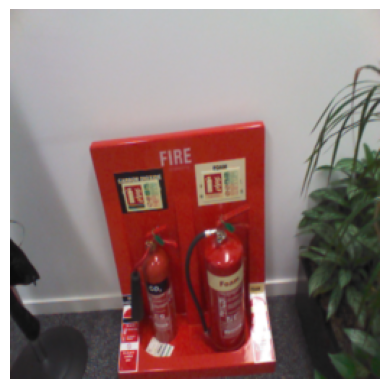

In [9]:
import matplotlib.pyplot as plt

# Visualizes an image in order to know if data is loaded properly to dataloader or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.axis(False);

In [10]:
# Load the pre-trained Swin Transformer model
model = timm.create_model('swinv2_small_window16_256.ms_in1k', pretrained=True, num_classes = 7)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/204M [00:00<?, ?B/s]

In [11]:
import torch
import torch.nn.functional as F
import numpy as np

def pose_err(est_pose, gt_pose):
    """
    Calculate the position and orientation error given the estimated and ground truth pose(s
    :param est_pose: (torch.Tensor) a batch of estimated poses (Nx7, N is the batch size)
    :param gt_pose: (torch.Tensor) a batch of ground-truth poses (Nx7, N is the batch size)
    :return: position error(s) and orientation errors(s)
    """
    posit_err = torch.norm(est_pose[:, 0:3] - gt_pose[:, 0:3], dim=1)
    est_pose_q = F.normalize(est_pose[:, 3:], p=2, dim=1)
    gt_pose_q = F.normalize(gt_pose[:, 3:], p=2, dim=1)
    inner_prod = torch.bmm(est_pose_q.view(est_pose_q.shape[0], 1, est_pose_q.shape[1]),
                           gt_pose_q.view(gt_pose_q.shape[0], gt_pose_q.shape[1], 1))
    orient_err = 2 * torch.acos(torch.abs(inner_prod)) * 180 / np.pi
    return posit_err, orient_err

In [12]:
class CameraPoseLoss(nn.Module):
    """
    A class to represent camera pose loss
    """

    def __init__(self):
        """
        :param config: (dict) configuration to determine behavior
        """
        super(CameraPoseLoss, self).__init__()
        self.learnable = True
        self.s_x = torch.nn.Parameter(torch.Tensor([0]), requires_grad=self.learnable)
        self.s_q = torch.nn.Parameter(torch.Tensor([-3]), requires_grad=self.learnable)
        self.norm = 2

    def forward(self, est_pose, gt_pose):
            """
            Forward pass
            :param est_pose: (torch.Tensor) batch of estimated poses, a Nx7 tensor
            :param gt_pose: (torch.Tensor) batch of ground_truth poses, a Nx7 tensor
            :return: camera pose loss
            """

            # Position loss
            l_x = torch.norm(gt_pose[:, 0:3] - est_pose[:, 0:3], dim=1, p=self.norm).mean()
            # Orientation loss (normalized to unit norm)
            l_q = torch.norm(F.normalize(gt_pose[:, 3:], p=2, dim=1) - F.normalize(est_pose[:, 3:], p=2, dim=1),
                             dim=1, p=self.norm).mean()

            if self.learnable:
                return l_x * torch.exp(-self.s_x) + self.s_x + l_q * torch.exp(-self.s_q) + self.s_q
            else:
                return self.s_x*l_x + self.s_q*l_q

In [13]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [14]:
import torch
from torch.optim import Adam
import torch.nn as nn
from tqdm import tqdm
import pickle

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
early_stopper = EarlyStopper(patience=50, min_delta=0)

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device, save_dir=None):
    train_losses = []
    test_losses = []
    test_losses_coor = []
    test_losses_orien = []

    for epoch in range(epochs):
        # Training loop
        model.train()
        train_loss = 0.0
        for images, targets in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs} - Training"):
            # Move data to device
            images = images.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = loss_fn(outputs, targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            train_loss += loss.item()

        # Compute average training loss for this epoch
        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Evaluation loop
        model.eval()
        test_loss = 0.0

        test_loss_coor = 0.0  # For tracking loss of the first 3 elements
        test_loss_orien = 0.0

        with torch.no_grad():
            for images, targets in tqdm(test_dataloader, desc=f"Epoch {epoch + 1}/{epochs} - Evaluation"):
                # Move data to device
                images = images.to(device)
                targets = targets.to(device)

                # Forward pass
                outputs = model(images)

                # Compute separate losses for coor&orien
                loss_coor, loss_orien = pose_err(outputs, targets)

                # Accumulate test loss and losses for the parts separately
                test_loss += loss_fn(outputs, targets).item()
                test_loss_coor += loss_coor.mean().item()
                test_loss_orien += loss_orien.mean().item()

            # Compute average test loss for this epoch
            avg_test_loss = test_loss / len(test_dataloader)
            test_losses.append(avg_test_loss)

            # Compute average losses for the parts during testing
            avg_test_loss_coor = test_loss_coor / len(test_dataloader)
            avg_test_loss_orien = test_loss_orien / len(test_dataloader)

            # Print the losses for the first 3 elements and last 4 elements separately
            print(f"\nEpoch {epoch + 1}/{epochs}, Test Loss Coordinate: {avg_test_loss_coor:.4f}, "
                  f"Test Loss Orientation: {avg_test_loss_orien:.4f}")

            # Append losses to separate lists
            test_losses_coor.append(avg_test_loss_coor)
            test_losses_orien.append(avg_test_loss_orien)

            # Print training and validation loss for this epoch
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

            if early_stopper.early_stop(avg_test_loss):
                save_checkpoint(model, optimizer, epoch, avg_train_loss, avg_test_loss, save_dir)

                # Save train and test losses
                train_loss_path = f"swin_checkpoints/train_loss_epoch_{epoch + 1}.txt"
                with open(train_loss_path, 'w') as f:
                    f.write(str(avg_train_loss))

                test_loss_path = f"swin_checkpoints/test_loss_epoch_{epoch + 1}.txt"
                with open(test_loss_path, 'w') as f:
                    f.write(str(avg_test_loss))

                # Save losses for the coor and orien part separately
                test_loss_coor_path = f"{save_dir}/test_loss_coor_epoch_{epoch + 1}.txt"
                with open(test_loss_coor_path, 'w') as f:
                    f.write(str(avg_test_loss_coor))

                test_loss_orien_path = f"{save_dir}/test_loss_orien_epoch_{epoch + 1}.txt"
                with open(test_loss_orien_path, 'w') as f:
                    f.write(str(avg_test_loss_orien))

                return {
                    'train_losses': train_losses,
                    'test_losses': test_losses,
                    'test_losses_coor': test_losses_coor,
                    'test_losses_orien': test_losses_orien
                }

        # Save the model and loss values every 50 epochs
        if (epoch + 1) % 50 == 0 and save_dir is not None:
            save_checkpoint(model, optimizer, epoch, avg_train_loss, avg_test_loss, save_dir)

            # Save train and test losses
            train_loss_path = f"swin_checkpoints/train_loss_epoch_{epoch + 1}.txt"
            with open(train_loss_path, 'w') as f:
                f.write(str(avg_train_loss))

            test_loss_path = f"swin_checkpoints/test_loss_epoch_{epoch + 1}.txt"
            with open(test_loss_path, 'w') as f:
                f.write(str(avg_test_loss))

            # Save losses for the coor and orien part separately
            test_loss_coor_path = f"{save_dir}/test_loss_coor_epoch_{epoch + 1}.txt"
            with open(test_loss_coor_path, 'w') as f:
                f.write(str(avg_test_loss_coor))

            test_loss_orien_path = f"{save_dir}/test_loss_orien_epoch_{epoch + 1}.txt"
            with open(test_loss_orien_path, 'w') as f:
                f.write(str(avg_test_loss_orien))

    return {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'test_losses_coor': test_losses_coor,
        'test_losses_orien': test_losses_orien
    }

def save_checkpoint(model, optimizer, epoch, train_loss, test_loss, save_dir):
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    # Save model checkpoint
    checkpoint_path = os.path.join(save_dir, f"epoch_{epoch + 1}_checkpoint.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'test_loss': test_loss
    }, checkpoint_path)



# Assuming you have already defined your model, train and test dataloaders, optimizer, and device
optimizer = Adam(model.parameters(), lr=1e-5)
loss_fn = CameraPoseLoss().to(device)
save_dir = "swin_checkpoints"

results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=1000,
                device=device,
                save_dir=save_dir)

with open('swin_checkpoints/results.pkl', 'wb') as f:
    pickle.dump(results, f)

Epoch 1/1000 - Evaluation: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it]



Epoch 1/1000, Test Loss Coordinate: 0.6811, Test Loss Orientation: 24.8792
Epoch 1/1000, Train Loss: 1.9018, Test Loss: 2.0086


Epoch 2/1000 - Evaluation: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]



Epoch 2/1000, Test Loss Coordinate: 0.5444, Test Loss Orientation: 20.4679
Epoch 2/1000, Train Loss: -1.1147, Test Loss: 1.1092


Epoch 3/1000 - Evaluation: 100%|██████████| 63/63 [01:01<00:00,  1.03it/s]



Epoch 3/1000, Test Loss Coordinate: 0.4590, Test Loss Orientation: 19.7514
Epoch 3/1000, Train Loss: -1.6714, Test Loss: 0.8998


Epoch 4/1000 - Training:   3%|▎         | 2/63 [00:04<02:27,  2.41s/it]


KeyboardInterrupt: 